This Script is for Running longer simulations of a standar PBDE set up with their different States using probabilities without POC

In [73]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [74]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    path2 = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        path = os.path.join(path2, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
        if not os.path.exists(path):    
            raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [75]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs',
'home': '/home/vvalenzuela/MOAD/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/animations'}

In [76]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [77]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return np.array(timestamps, dtype='datetime64')

def find_temp(rootdir):
    dirs=[]
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dirs.append(d)
    temp=sorted(dirs, key=lambda x: os.path.getctime(x), reverse=True)[:1][0]
    return temp[-12:]

def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

In [78]:
#Definitions
start = datetime(2022, 1, 1) #Start date
length = 1 # Set Time length [days] 
dt = 1#90 #toggle between - or + to pick backwards or forwards 
N = 1 # 1000   # number of  locations
# Here the number of particles needs to be associated to the discharge rates from the Iona Outfall
n = 10 # number of particles per location
dmin = 60#minimum depth
dd = 20 #max depth difference from dmin
dtp = 0
odt = 1 
rrr = 1e3

In [79]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(datetime(2022, 1, 1),path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [80]:
#Set deploy coordinates following yaml   
clat = [49.195045]
clon = [-123.301956]
#
a, b = finder(clat[0], clon[0])
print ("The total depth at this location is", mask.totaldepth[a, b].values, 'm')
#
duration = timedelta(days=length)
#
x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)
#
lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

The total depth at this location is 85.375 m


In [81]:
# Files for states runs
name_states = 'Test_sewage_particles_'+str(length)+'_days_' 
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name_states + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_states = os.path.join(path['out'], fn)
#
local = 0

In [82]:
varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol','last_cell_index']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
density = Field.from_netcdf(filenames['R'], variables['R'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(density)
#
#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)
#
#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
MBATHY = Field.from_netcdf(filenames['last_cell_index'], variables['last_cell_index'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(MBATHY)
field_set.add_field(Bth)
field_set.add_field(TD)
#
#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)
#
# Add e3t
varlist = ['cell_size']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht', 'time': 'time_counter'}
E3T = Field.from_netcdf(filenames['cell_size'], variables['cell_size'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(E3T)
#
# Add mbathy
#
#varlist = ['last_cell_index']
#filenames,variables=filename_set(start,length,varlist)
#dimensions = {'lon': 'glamt', 'lat': 'gphit', 'time' : 't'}
#MBATHY = Field.from_netcdf(filenames['last_cell_index'], variables['last_cell_index'], dimensions,allow_time_extrapolation=True, chunksize='auto')
#field_set.add_field(MBATHY.data[0,:,:])

/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(lonlat_filename, dimensions, indices, netcdf_engine) as filebuffer:
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded properly by xarray (version 2024.3.0). It will be opened with no decoding. Filling values might be wrongly parsed.
  with _grid_fb_class(lonlat_filename, dimensions, indices, netcdf_engine) as filebuffer:
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:511: FileWarning: File /ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc could not be decoded prope

In [83]:
#path_coords = '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc'
#coords = xr.open_dataset(path_coords, decode_times=False)

In [84]:
#path_bat = '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc'
#bat_file = xr.open_dataset(path_bat)
#mbathy = bat_file['mbathy'][0]
#
#mbathy_field = Field('mbathy', mbathy, lon=coords['glamt'][0], lat=coords['gphit'][0], time=None)
#


In [85]:
#mbathy_file = xr.Dataset(data_vars=dict(mbathy=(["y", "x"], mbathy.data))
#                , attrs=dict(description="Timeless mbathy"))
#mbathy_file.to_netcdf('timeless_mbathy.nc')                

In [86]:
#mbathy_field = Field('mbathy', mbathy_file['mbathy'], lon=coords['glamt'][0], lat=coords['gphit'][0], time=None)


In [87]:

####################################################### ADD IF USING POC or DOC###################################################################
# Fieldest for PON 
#varlist=['PON', 'DIATO', 'FLAGE']
#filenames, variables = filename_set(start, length, varlist)
#dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'deptht','time': 'time_counter'}
#PON=Field.from_netcdf(filenames['PON'], variables['PON'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#DIATO=Field.from_netcdf(filenames['DIATO'], variables['DIATO'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#FLAGE=Field.from_netcdf(filenames['FLAGE'], variables['FLAGE'], dimensions, allow_time_extrapolation=True, chunksize='auto')
#
#field_set.add_field(PON)
#field_set.add_field(DIATO)
#field_set.add_field(FLAGE)

In [88]:
# Define PARTICLE TYPE and variables within itself
class MPParticle(JITParticle):    
    n = Variable('n', initial = n)
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0)
    initialized = Variable('initialized', initial = 0)
    status = Variable('status') # different status for different processes
    release_time = Variable('release_time', initial = field_set.time_origin.fulltime(0))

Maybe I can add a different variables for MP resuspended and C resuspended, independent from 'status', to get 0 when it's not resuspended and 1 when it's resuspended...

In [89]:
pset_states = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=odt))

$$\textbf{Kernels!}$$

From Sun et al. (2023), Johannssen et al. (2005) and among other cited papers there is a linear relation between more PBDEs in colloidal form and POC concentrations.

Using this criteria we can change our random absorption and desorption values to the POC obtained by the Redfield Ratio from the Particulate Organic Nitrogen in the Salish Sea Cast Model.

Lets check our equation again:


From Sun et al. 2023 we obtain a partitioning relation of PBDEs between dissolved and particulate states:



$K_{oc,a} = [PBDE]_p / ([PBDE]_{d,c} \cdot [POC])$


Assuming that $K_{oc,a}$ is a constant, then we can get the following relation for POC:

$[POC] = \frac{[PBDE]_p}{[PBDE]_{d,c}} \cdot \frac{1}{K_{oc,a}}$


So, 


- IF $[POC]$ is HIGH $\Rightarrow$ HIGH $[PBDE]_p$ is expected 

- IF $[POC]$ is LOW $\Rightarrow$ HIGH $[PBDE]_{d,c}$ is expected 


Rewritting it, we can get:


$[POC] \cdot K_{oc,a} = \frac{[PBDE]_p}{[PBDE]_{d,c}}$

So, if we have our mean POC value from the Model, we can get an estimate of Particulate and Dissolved PBDEs as follows:

- IF $[POC] \cdot K_{oc,a}$ is HIGHER than $[POC]_{mean}$ $\Rightarrow$ HIGH $[PBDE]_p$ is expected

- IF $[POC] \cdot K_{oc,a}$ is LOWER than $[POC]_{mean}$ $\Rightarrow$ HIGH $[PBDE]_p$ is expected 






Table of mean POC values per region:


|| Northern Strait of Georgia | Central Strait of Georgia | Sothern Strait of Georgia |
|--------------------------| -------------------------- | ------------------------- | ------------------------- |
| $\textbf{POC}$ $[mmol m^{-3}]$ | $\textbf{0.04270812763156844}$ |  $\textbf{0.04049420431621519}$ |  $\textbf{0.0454328345755736}$ |
| $\textbf{POC}$ $[Kg / L]$ | $\textbf{0.0005129545085444791}$ |  $\textbf{0.00048636373978076585}$ |  $\textbf{0.0005456801462368419}$ |



In [90]:
aaaa = ParcelsRandom.random() * (1/3600)
abso = 3.2/(24*3600)

if aaaa < abso:
    print('This is super TRUE')
else:
    print('Or maybe not that TRUE')


Or maybe not that TRUE


In [91]:
def test(particle, fieldset, time):
    if particle.time < 3600:
        particle.status = 1
    else:
        particle.status = 2    

In [92]:
# Just for the beginning, not at every time!!
def PBDEs_states(particle, fieldset, time):
    if particle.time < 3600:#particle.initialized == 0:
        n = particle.n 
        # n is the total amount of particles released at the starting location
        data = ParcelsRandom.randint(0, n-1)
       # print('States Kernel is Running')

        #
        # PBDEs as Sewage Particles
        if data < 3*(n/4):
            particle.status = 1
            #print('Particle in Status 1')
        #
        # Colloidal/Dissolved PBDEs
        else:
            particle.status = 2
    ##################################################################################    
    else:
        abso = 0.038/(24) #per hour
        deso_s = 3.2/(24) #per hour
        deso_m = 1.6/(24) #per hour
        dt = 1/3600
        #print('Process Kernel is Running')
        value = ParcelsRandom.random() * dt
        if particle.status == 1 and value < (deso_s * dt):
            particle.status = 2
            #print('Particle from Status 1 to Status 2 is TRUE')

            # From Sewage Particle to Colloidal/Dissolved PBDE form
        elif particle.status == 2 and value < (abso * dt):
            particle.status = 3
            #print('Particle from Status 2 to Status 3 is TRUE')
            # From Coloidal/Dissolved form to being attached to a Marine Particle           
        elif particle.status == 3 and value < (deso_m * dt):
            particle.status = 2
            #print('Particle from Status 3 to Status 2 is TRUE')
            # From a Marine Particle to a Colloidal/Dissolved form           

    #particle.initialized = 1        

In [93]:
def process(particle, fieldset, time):
# After PBDEs are out from the pipe, they can absorbe into marine particles. 
# And , from marine particles they can desorbe into colloidal/dissolved PBDEs
    abso = 0.038/(24) #per hour
    deso_s = 3.2/(24) #per hour
    deso_m = 1.6/(24) #per hour
    dt = 1/3600
    #print('Process Kernel is Running')

    if particle.time >= 3600:#particle.initialized == 1:
        value = ParcelsRandom.random() * dt
        if particle.status == 1 and value < (deso_s * dt):
            particle.status = 2
            #print('Particle from Status 1 to Status 2 is TRUE')

            # From Sewage Particle to Colloidal/Dissolved PBDE form
        elif particle.status == 2 and value < (abso * dt):
            particle.status = 3
            #print('Particle from Status 2 to Status 3 is TRUE')
            # From Coloidal/Dissolved form to being attached to a Marine Particle           
        elif particle.status == 3 and value < (deso_m * dt):
            particle.status = 2
            #print('Particle from Status 3 to Status 2 is TRUE')
            # From a Marine Particle to a Colloidal/Dissolved form      
      

In [94]:
def PBDEs_forms(particle, fieldset, time):
    #print('PBDEs_forms Kernel is Running')
    #### Lets say that the sinking rate of Sewage Particles is 3 times faster than the one for Marine Particles ####
    # Sinking velocity for PBDEs in sewage particles
    dt = 1/3600
    if particle.status == 1:
        sinkvel = 100*(dt) # m/hr * dt --> to seconds
        particle.depth += sinkvel * particle.dt
    # Sinking velocity when colloids (just float around)        
    elif particle.status == 2:
        sinkvel = 0.0*(dt)
        particle.depth += sinkvel * particle.dt
    # Sinking velocity for PBDEs in marine particles
    elif particle.status == 3:
        sinkvel = 35*(dt) # m/hr * dt --> to seconds
        particle.depth += sinkvel * particle.dt         

In [95]:
def Advection(particle, fieldset, time): 
    # Advection Kernel for particles in any state apart from status == 4 (at the bottom)
    #
    if particle.status == 1 or particle.status == 2 or particle.status == 3: # or particle.status == 5 or particle.status == 6:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t) sea surface height
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt) sea surface height in the next time step
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth 
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/(td+ssh)
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

In [96]:
def turb_mix(particle,fieldset,time):
    #print('Turb_mix Kernel is Running')
    if particle.status == 1 or particle.status == 2 or particle.status == 3: # or particle.status == 5 or particle.status == 6:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact

Idea behind resuspenssion Kernel:

- After particles are setteld at the bottom, reaching status 4, if bottom velocities reach a critical value, then PBDEs are resuspended in the form of Colloids (Status = 2), being scavanged away. A part is also resuspended in Particulate form, but since they sink really fast, then we can neglect it.

- 'Question': How can we set it up? What do we need for this Kernel? (checked) :D

In [97]:
def Displacement(particle,fieldset,time):
    #print('Displacement Kernel is Running')
    '''Apply movement calculated by other kernels'''
    if particle.time >= 3600: # or particle.status == 5 or particle.status == 6:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td:
            particle.depth  = td # Get particles attached to the bottom when they reach it
            particle.status = 4
            #print('Particle reached the bottom (Status 4)')
        #
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        #
        else:
            particle_ddepth += dzs #apply mixing 

In [98]:
def resuspension(particle, fieldset, time):
    if particle.status == 4 and particle.time >= 3600:
        threshold = 1 # threshold for particles to know when to resuspend
        # Calculation of U_star, which is proportional to the bottom stress (tau)
        k = 0.42
        z_star = 0.07
        u_horizontal = (1/4) * (fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon -1]) ** 2
        v_horizontal = (1/4) * (fieldset.V[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat, particle.lon] + fieldset.U[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] - 1, particle.lat - 1, particle.lon]) ** 2
        vel_horizontal = (u_horizontal + v_horizontal) ** (1/2)
 
        u_star = (vel_horizontal * k) / ((math.log(fieldset.e3t[time, fieldset.mbathy[time, particle.depth, particle.lat, particle.lon] -1, particle.lat, particle.lon] / 2) / z_star))
        # Here tau is the bottom friction parameter estimated from (u_starr)^2 x density
        tau = ((u_star) ** 2) * 1024#(fieldset.sigma_theta[particle.time, fieldset.mbathy - 1, particle.lat, particle.lon] + 1000)
        #
        #############
        frac_value = ParcelsRandom.randint(0,10)
        if tau > threshold and frac_value >= 3: # for colloids
            #particle.status = 5
            particle.status = 2
            #print('Above Threshold!! Particle resuspended as colloid (Status 5)')
        #
        elif tau > threshold and frac_value < 3: # for marine particles
            #particle.status = 6
            particle.status = 3
            #print('Above Threshold!! Particle resuspended as particle (Status 6)')
        elif tau < threshold:
            particle.status = 4
            #print('particles stays at the bottom, NOT BEING RESUSPENDED')    

In [99]:
def export(particle,fieldset,time):
    if particle.lat<48.7 and particle.lon < -124.66:
        particle.status = 7

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success

Check Kernel... **WHY THERE'S NOT SEWAGE PARTICLES??!!!**

In [100]:
#pset_states.execute([states, process, PBDEs_forms, Advection, turb_mix, Displacement, resuspension, CheckOutOfBounds, export, KeepInOcean],
#            runtime=duration, 
#            dt=dt,
#            output_file=pset_states.ParticleFile(name=outfile_states, outputdt=timedelta(hours=odt))) 
#
pset_states.execute([PBDEs_states, PBDEs_forms, Advection, turb_mix, Displacement, resuspension, CheckOutOfBounds, export, KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset_states.ParticleFile(name=outfile_states, outputdt=timedelta(hours=odt))) 

/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/ast.py:418: KernelWarning: Don't change the location of a particle directly in a Kernel. Use particle_dlon, particle_dlat, etc.
  return visitor(node)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/kernel.py:251: KernelWarning: dt declared in multiple Kernels
  kernel_ccode = kernelgen.generate(deepcopy(self.py_ast), self.funcvars)
/home/vvalenzuela/conda_envs/Parcels/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in /home/vvalenzuela/MOAD/Ocean_Parcels/results/PBDE_runs/Test_sewage_particles_1_days_20220101_1n_20220102_1n.zarr.
100%|██████████| 86400.0/86400.0 [01:58<00:00, 730.72it/s] 


In [101]:
ds1 = xr.open_zarr(outfile_states)
depth1 = ds1.z*ds1.fact

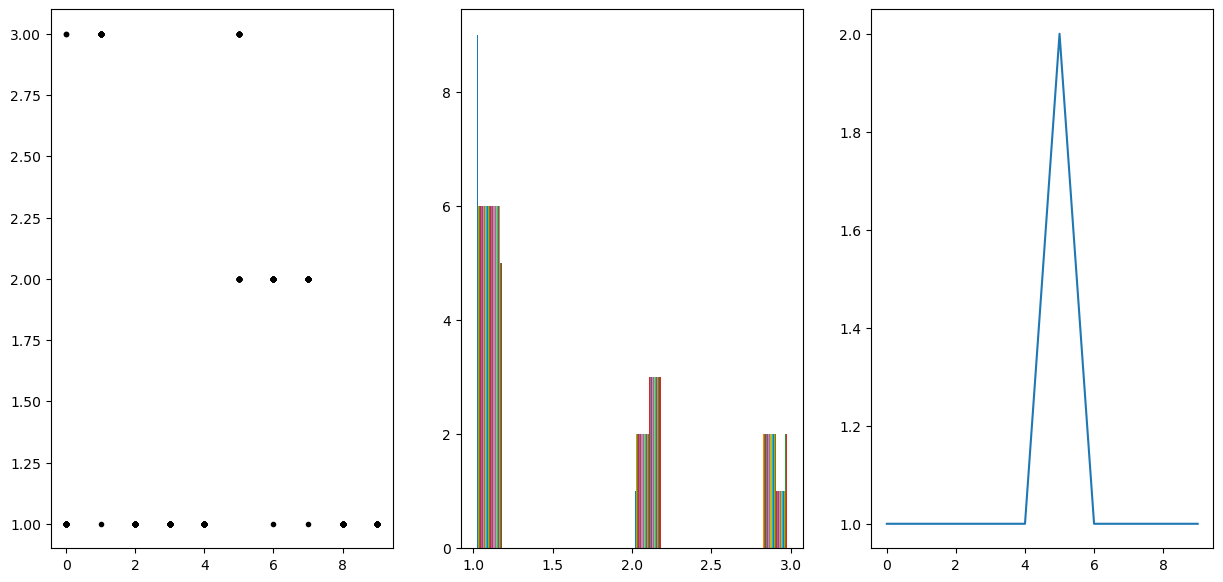

In [102]:
fig, ax = plt.subplots(1,3,figsize=(15,7))
ax[0].plot(ds1.status, '.k')
#
ax[1].hist(ds1.status)
#
ax[2].plot(ds1.status[:,0])


In [ ]:
ii = np.where(ds1.status[:,0] == 2)[0]
jj = np.where(ds1.status[:,0] == 1)[0]
kk = np.where(ds1.status == 4)

In [ ]:
plt.plot(ds1.status[kk[0][6],:])

-States kernel is working ok; it's keeping the initial state for each particle through time.


-Process Kernel it seems to be overwriting the States Kernel, letting particles to change just between status 2 and 3


-PBDEs_forms Kernel is not affecting the other Kernels, since it's just changing a direct property of the particles, not changing their status


In [ ]:
fig,axs=plt.subplots(2,2,figsize=(14,10))

axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c='r',s=5)
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

# Make map
blevels = list(np.arange(0,500,100))

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c='r',s=5)
axs[0,1].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title('Particles location at t = 0')

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,-1],ds1.lat[:,-1],zorder=3,c='b',s=5)
axs[1,0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))

axs[1,1].scatter(ds1.lat[:,-1],depth1[:,-1],zorder=3,c='b',s=5)
axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[-1]+1))
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
plt.suptitle('Particles from Iona Outfall Depths ' + str(daterange[0]) + ' to ' + str(daterange[-1]))

In [ ]:
lat = ds1['lat']
lon = ds1['lon']
status = ds1['status']
depth = ds1.z*ds1.fact
#time_hr = pd.date_range(start=start, end=start+timedelta(length), freq='H')[:-1]

In [ ]:
total = len(ds1.obs) * len(ds1.trajectory)
a,b = np.where(ds1.status == 2)
a1,b1 = np.where(ds1.status == 3)
a2,b2 = np.where(ds1.status == 4)

In [ ]:
idx_end_status3 = np.where(ds1.status[:,-1] == 3.)[0]
idx_end_status2 = np.where(ds1.status[:,-1] == 2.)[0]
idx_end_status4 = np.where(ds1.status[:,-1] == 4.)[0]

In [ ]:
len(idx_end_status3)

In [ ]:
per_end_status2 = (len(idx_end_status2) / len(ds1.trajectory))*100
per_end_status3 = (len(idx_end_status3) / len(ds1.trajectory))*100
per_end_status4 = (len(idx_end_status4) / len(ds1.trajectory))*100

How many particles ended up as Colloids, Marine Particles and "at the Bottom"?

In [ ]:
print(str(np.round(per_end_status2,3)) + r' % of the particles ended up as Colloids')
print(str(np.round(per_end_status3,3)) + r' % of the particles ended up as Marine Particles')
print(str(np.round(per_end_status4,3)) + r' % of the particles ended up at the Bottom')

In [ ]:
###########check the resuspended ones .......

In [ ]:
#aa = np.where(ds1.status[idx_end_status2,:] == 4.)[0]
#colloidal_resuspended = (len(aa) / len(idx_end_status2)) * 100
#print(str(np.round((len(aa) / len(idx_end_status2)) * 100, 3)) + ' % of the Particles that ended are as colloids reached the bottom and were resuspended')
#
#bb = np.where(ds1.status[idx_end_status3,:] == 4.)[0]
#MP_resuspended = (len(bb) / len(idx_end_status3)) * 100
#print(str(np.round((len(bb) / len(idx_end_status3)) * 100, 3)) + ' % of the Particles that ended are as marine particles reached the bottom and were resuspended')

From status 2 and 3, separate the ones that ocurred after status 4. By doing this we can know which ones where resuspended!!

In [ ]:
per_status2 = (len(a) / total) * 100
per_status3 = (len(a1) / total) * 100
per_status4 = (len(a2) / total) * 100

In [ ]:
print('Percentage of Status 2: ' + str(per_status2))
print('Percentage of Status 3: ' + str(per_status3))
print('Percentage of Status 4: ' + str(per_status4))
#print('Percentage of Status 5: ' + str(per_status5))
#print('Percentage of Status 6: ' + str(per_status6))

Lets first see how much particles goes through each one of the 3 status:

In [ ]:
blevels = list(np.arange(0,600,100))
#
fig,axs=plt.subplots(2,2,figsize=(14,10))
im=axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[0,0].scatter(lon.where(status==2),lat.where(status==2),zorder=3,c='r',s=2, label = 'Colloidal')
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([clat[0]-1.5,clat[0]+1])
axs[0,0].set_xlim([clon[0]-1.5,clon[0]+1])
axs[0,0].legend()
axs[0,0].set_title(str(np.round(per_status2,3)) + r' % of particles go through a Colloidal state')
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')

#axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))
#
im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[0,1].scatter(lon.where(status==3),lat.where(status==3),zorder=3,c='g',s=2, label = 'Marine Particle')
axs[0,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-1.5,clat[0]+1])
axs[0,1].set_xlim([clon[0]-1.5,clon[0]+1])
axs[0,1].legend()
axs[0,1].set_title(str(np.round(per_status3,3)) + r' % of particles go through a Marine Particle state')
axs[0,1].set_xlabel('Longitude')
axs[0,1].set_ylabel('Latitude')

#
im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[1,0].scatter(lon.where(status==4),lat.where(status==4),zorder=3,c='b',s=2, label = 'At Bottom')
axs[1,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-1.5,clat[0]+1])
axs[1,0].set_xlim([clon[0]-1.5,clon[0]+1])
axs[1,0].legend()
#axs[1,0].set_title('At bottom: ' + str(np.round(per_status4,3)) + ' %' + '\n Colloidal Resuspended: ' + str(np.round(per_status5,3)) + ' %' + '\n Particulate Resuspended: ' + str(np.round(per_status6,3)) + ' %')
axs[1,0].set_title(str(np.round(per_status4,3)) + r' % of particles get sedimented at the bottom')
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
#
axs[1,1].scatter(lat.where(status==2),depth.where(status==2),zorder=3,c='r',s=2)
axs[1,1].scatter(lat.where(status==3),depth.where(status==3),zorder=3,c='g',s=2)
axs[1,1].scatter(lat.where(status==4),depth.where(status==4),zorder=3,c='b',s=2)
axs[1,1].set_xlabel('Latitude')
axs[1,1].grid(linestyle = '--')

axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=20)
axs[1,1].set_ylim([500,0])
#
#cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
#cbar.set_label('Depth [m]')
#
plt.suptitle('Particles at ALL Times (Resuspension added) \n ' + str(length) + ' Days Simulation')
#
plt.tight_layout()

In the figure above we are looking at how many times did all of the particles at ALL times went through each one of the states. So, the percentages goes like:

- The amount of particles in particle.status = 2, 3 and 4 is divided by the total amount of particles, which is (ds1.obs $\times$ ds1.trajectory) 

In [ ]:
blevels = list(np.arange(0,600,100))
#
fig,axs=plt.subplots(2,2,figsize=(14,10))
im=axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[0,0].scatter(lon[idx_end_status2,-1],lat[idx_end_status2,-1],zorder=3,c='r',s=2 , label = 'End as Colloidal')
#axs[0,0].scatter(lon[aa,:],lat[aa,:],zorder=3,c='c',s=2, alpha = 0.5 , label = 'Resuspended')
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([clat[0]-1.5,clat[0]+1])
axs[0,0].set_xlim([clon[0]-1.5,clon[0]+1])
axs[0,0].legend()
axs[0,0].set_title(str(np.round(per_end_status2,3)) + r' % ended up in a Colloidal state')# + '\n' + str(np.round(colloidal_resuspended,3)) + r'% were resuspended')
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Latitude')
#axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))
#
im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[0,1].scatter(lon[idx_end_status3,-1],lat[idx_end_status3,-1],zorder=3,c='g',s=2, label = 'End as M. Particle')
#axs[0,1].scatter(lon[bb,:],lat[bb,:],zorder=3,c='m',s=2, alpha = 0.5 , label = 'Resuspended')
axs[0,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-1.5,clat[0]+1])
axs[0,1].set_xlim([clon[0]-1.5,clon[0]+1])
axs[0,1].legend()
axs[0,1].set_title(str(np.round(per_end_status3,3)) + r' % ended up in a Marine Particle state')# + '\n' + str(np.round(MP_resuspended,3)) + r'% were resuspended')
axs[0,1].set_xlabel('Longitude')
axs[0,1].set_ylabel('Latitude')

#
im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='grey',levels=[-1,0])
axs[1,0].scatter(lon[idx_end_status4,-1],lat[idx_end_status4,-1],zorder=3,c='b',s=2, label = 'End at Bottom')
axs[1,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-1.5,clat[0]+1])
axs[1,0].set_xlim([clon[0]-1.5,clon[0]+1])
axs[1,0].legend()
#axs[1,0].set_title('At bottom: ' + str(np.round(per_status4,3)) + ' %' + '\n Colloidal Resuspended: ' + str(np.round(per_status5,3)) + ' %' + '\n Particulate Resuspended: ' + str(np.round(per_status6,3)) + ' %')
axs[1,0].set_title(str(np.round(per_end_status4,3)) + r' % ended up at the Bottom')
axs[1,0].set_xlabel('Longitude')
axs[1,0].set_ylabel('Latitude')
#
axs[1,1].scatter(lat[idx_end_status2,-1], depth[idx_end_status2,-1],zorder=3,c='r',s=1.5)
axs[1,1].scatter(lat[idx_end_status3,-1], depth[idx_end_status3,-1],zorder=3,c='g',s=1.5)
axs[1,1].scatter(lat[idx_end_status4,-1], depth[idx_end_status4,-1],zorder=3,c='b',s=1.5)
#axs[1,1].scatter(lat[aa,:], depth[aa,:],zorder=3,c='c',s=1.5)
#axs[1,1].scatter(lat[bb,:], depth[bb,:],zorder=3,c='m',s=1.5)
axs[1,1].set_xlabel('Latitude')

axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=20)
axs[1,1].set_ylim([500,0])
axs[1,1].grid(linestyle = '--')
axs[1,1].set_ylabel('Depth(m)')
#
#cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
#cbar.set_label('Depth [m]')
#
plt.suptitle('Final state of particles (Resuspension added)  \n ' + str(length) + ' Days Simulation')
#
plt.tight_layout()


Lets look at individual particles, to see how it's evolving through different states

In [ ]:
plt.plot(ds1.status[5,:])
plt.plot(ds1.RE_MP[5,:])
plt.plot(ds1.RE_C[5,:])

In [ ]:
idx = 5
fig, axs = plt.subplots(figsize = (14,5))
axs.scatter(lat[idx,:].where(ds1.status[idx,:] == 2.0), depth[idx,:].where(ds1.status[idx,:] == 2.0),zorder=3,c='r',s=4)
axs.scatter(lat[idx,:].where(ds1.status[idx,:] == 3.0), depth[idx,:].where(ds1.status[idx,:] == 3.0),zorder=3,c='g',s=4)
axs.scatter(lat[idx,:].where(ds1.status[idx,:] == 4.0), depth[idx,:].where(ds1.status[idx,:] == 4.0),zorder=3,c='b',s=4)
#
axs.scatter(lat[idx,:].where(ds1.RE_C[idx,:] == 1.0), depth[idx,:].where(ds1.RE_C[idx,:] == 1.0),zorder=3,c='c',s=4, marker = 'd')
axs.scatter(lat[idx,:].where(ds1.RE_MP[idx,:] == 1.0), depth[idx,:].where(ds1.RE_MP[idx,:] == 1.0),zorder=3,c='m',s=4, marker = 'd')


axs.set_xlabel('Latitude')

axs.scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=20)
axs.set_ylim([500,0])
axs.grid(linestyle = '--')
axs.set_ylabel('Depth(m)')

In the case of the figure above, we are looking at what is the last state that the particle went through during the simulation. This means that we are comparing:

 - ds1.status[idx, -1] for status 2, 3 and 4 is divided for the amount of particles deployed (ds1.trajectory) 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax.scatter(lon[:, 0], lat[:, 0],s=2, c='k')
ax.scatter(clon[0],clat[0], zorder=3, c='r', marker='*',s=30)
#ax.legend()
ax.set_ylim([clat[0]-1,clat[0]+1])
ax.set_xlim([clon[0]-1,clon[0]+1])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
#ax.set_title('Deployed Particles from Iona (resuspension added)')
nmin, nmax = 0, -1
#
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles', artist='Vicente',
                comment='Particles movement (Year 2022)')
writer = FFMpegWriter(fps=30, metadata=metadata)

with writer.saving(fig, path['anim']+"/run_resuspension_added.mp4", 100):
    for tm in range(len(ds1.obs)):
        s = ax.scatter(lon[:, nmin:tm], lat[:, nmin:tm],s=2, c=depth[:,nmin:tm], cmap = 'jet')
        if tm == 0:  # Adding colorbar only once
            s.set_clim(depth.min().values, depth.max().values)
            cb1 = fig.colorbar(s, ax=ax)
            cb1.set_label('Status')
        ax.set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[tm]+1))
        writer.grab_frame()

In [ ]:
def update_plot(i,depth, axs):
    axs.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
    particles = axs.scatter(lon[:,i], lat[:,i], c=depth[:,i] )
    axs.set_title('Deployed Particles from Iona (resuspension added)')

In [ ]:
# Configure the Plot
fig, axs = plt.subplots( figsize=(8, 8))
axs.set_ylabel('Latitude')
axs.set_xlabel('Longitude')
axs.set_ylim([clat[0]-1,clat[0]+1])
axs.set_xlim([clon[0]-1,clon[0]+1])

ani = animation.FuncAnimation(fig, update_plot, frames=int(len(ds1.time[0])/100),
                    fargs=(depth, axs),
                    interval=100, blit=False, repeat=False) 
#
plt.close()

In [ ]:
t = 1000
#
fig,axs=plt.subplots(2,2,figsize=(14,10))

pp = axs[0,0].scatter(ds1.lat[:,0],depth1[:,0],zorder=3,c=ds1.status[:,0],s=5, cmap = 'jet')
axs[0,0].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[0,0].set_ylim([250,0])
axs[0,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

# Make map

im=axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[0,1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[0,1].scatter(ds1.lon[:,0],ds1.lat[:,0],zorder=3,c=ds1.status[:,0],s=5, cmap = 'jet')
axs[0,1].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[0,1].set_ylim([clat[0]-.5,clat[0]+.5])
axs[0,1].set_xlim([clon[0]-.5,clon[0]+.5])
axs[0,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[0]))

im=axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs[1,0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
axs[1,0].scatter(ds1.lon[:,t],ds1.lat[:,t],zorder=3,c=ds1.status[:,t],s=5. , cmap = 'jet')
axs[1,0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
axs[1,0].set_ylim([clat[0]-.5,clat[0]+.5])
axs[1,0].set_xlim([clon[0]-.5,clon[0]+.5])
axs[1,0].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[t]+1))

particles = axs[1,1].scatter(ds1.lat[:,t],depth1[:,t],zorder=3,c=ds1.status[:,t],s=5, cmap = 'jet')
axs[1,1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
axs[1,1].set_ylim([250,0])
axs[1,1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[t]+1))
#
cbar = fig.colorbar(im, ax=axs, location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
cbar1 = fig.colorbar(pp, ax=axs, location='right', shrink=0.8)
cbar1.set_label('Status')
#
plt.suptitle('Particles from Iona Outfall Depths ' + str(daterange[0]) + ' to ' + str(daterange[-1]))

In [ ]:
t = 1000

One particle plot / animation

In [ ]:
a4 = np.where(ds1.status == 4)
a3 = np.where(ds1.status == 3)
a2 = np.where(ds1.status == 2)
a1 = np.where(ds1.status == 1)

In [ ]:
p_num = a1[0]
fig, ax = plt.subplots(1,2,figsize = (12,6))
#
mapita=ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon[p_num,:],ds1.lat[p_num,:],zorder=3,c=ds1.status[p_num,:],s=5. , cmap = 'jet')
ax[0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
ax[0].set_ylim([clat[0]-.5,clat[0]+.5])
ax[0].set_xlim([clon[0]-.5,clon[0]+.5])
#
single = ax[1].scatter(ds1.lat[p_num,:],depth1[p_num,:],zorder=3,c=ds1.status[p_num,:],s=5, cmap = 'jet')
ax[1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
ax[1].set_ylim([250,0])
#
cbar = fig.colorbar(mapita, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
cbar1 = fig.colorbar(single, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Status')
#

BOTTOM MAPS

In [ ]:
aa = np.where(ds1.status[:,-1] == 4)
aa[0]

In [ ]:
x, y = finder(ds1.lat[0,0].values, ds1.lon[0,0].values)
print ("The total depth at this location is", mask.totaldepth[x, y].values, 'm', 'and the particle depth is ', ds1.z[0,0].values)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
particles = ax[0].scatter(ds1.lon[aa[0], -1], ds1.lat[aa[0], -1], s=5, c=ds1.z[aa[0], -1], cmap = cmap, vmin = 0, vmax = 170)
ax[0].set_ylim([clat[0]-1.5,clat[0]+1.5])
ax[0].set_xlim([clon[0]-2.0,clon[0]+.7])
ax[0].scatter(clon[0],clat[0], zorder=3, c='r', marker='*',s=30)

#ax[0].set_aspect(5/4.4)
ax[0].set_title('Particles at the Bottom (Status = 4)')
#
#bathy=ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap)#,levels=blevels)
ax[1].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
all_particles = ax[1].scatter(ds1.lon[:,t],ds1.lat[:,t],zorder=3,s=5, c=ds1.z[:, t], cmap = cmap, vmin = 0, vmax = 170)
ax[1].scatter(clon[0],clat[0], zorder=3, c='r', marker='*',s=30)
ax[1].set_ylim([clat[0]-1.5,clat[0]+1.5])
ax[1].set_xlim([clon[0]-2.0,clon[0]+.7])
ax[1].set_title(f'All Particles location at t = ' + str(ds1.time['obs'].values[t]+1))
#
cbar = fig.colorbar(particles, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Particles Depth [m]')

#
cbar1 = fig.colorbar(all_particles, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Bottom Depth [m]')


In [ ]:
print((len(ds1.z[aa[0],-1]) / len(ds1.z[:,-1])) *100, '% of Particles reach the bottom after ', length, ' days of simulation, between ' + str(daterange[0]) + ' and ' + str(daterange[-1]))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(19, 8))
im = ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax[0].contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax[0].scatter(ds1.lon[:, 0], ds1.lat[:, 0],s=2, c='k', cmap = 'jet')
ax[1].scatter(clat[0],dmin, zorder=3, c='k', marker='*',s=30)
ax[0].scatter(clon[0],clat[0], zorder=3, c='k', marker='*',s=30)
#ax.legend()
ax[0].set_ylim([clat[0]-.5,clat[0]+.5])
ax[0].set_xlim([clon[0]-.5,clon[0]+.5])
ax[0].set_aspect(5/4.4)
ax[1].set_ylim([250,0])
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_title(str(daterange[0]) + ' to ' + str(daterange[-1]))
nmin, nmax = 0, -1
#
cbar = fig.colorbar(im, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Depth [m]')
#
FFMpegWriter = animation.writers['ffmpeg']  
metadata = dict(title='Animation_Particles', artist='Vicente',
                comment='Particles movement (Year 2022)')
writer = FFMpegWriter(fps=12, metadata=metadata)

with writer.saving(fig, path['anim']+"/Year_run_PBDEs_no_POC.mp4", 100):
    for tm in range(len(ds1.obs)):
        s = ax[0].scatter(ds1.lon[:, nmin:tm], ds1.lat[:, nmin:tm],s=2, c=ds1.status[:,nmin:tm], cmap = 'jet')
        a = ax[1].scatter(ds1.lat[:,nmin:tm],depth1[:,nmin:tm],zorder=3,c=ds1.status[:,nmin:tm],s=5, cmap = 'jet')
        if tm == 0:  # Adding colorbar only once
            a.set_clim(ds1.status.min().values, ds1.status.max().values)
            cb1 = fig.colorbar(a, ax=ax[1])
            cb1.set_label('Status')
        ax[1].set_title(f'Particles location at t = ' + str(ds1.time['obs'].values[tm]+1))
        writer.grab_frame()